# Análisis y Predicción de Precios de Gasolina

Este notebook contiene:
1. Realizar el proceso ETL: Limpia, transforma y estructura los datos para que puedan ser utilizados en un modelo de regresión lineal.
2. Construir el modelo predictivo: Utiliza regresión lineal múltiple para estimar el precio de la gasolina en función del estado, mes y año.
3. Desarrollar una aplicación en Streamlit que permita al usuario:
    - Seleccionar un estado, mes y año desde un menú interactivo
    - Visualizar el precio estimado de la gasolina


## 1. Importación de Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')



## 2. Proceso ETL - Extracción, Transformación y Carga

### 2.1 Función de Expansión del Dataset

In [29]:
def expandir_dataset(archivo_entrada='Gasolina.csv', archivo_salida='Gasolina_expandido.csv'):
    """
    Transforma el dataset de gasolina de formato wide a long.
    Args:
        archivo_entrada (str): Nombre del archivo CSV de entrada
        archivo_salida (str): Nombre del archivo CSV de salida
    Returns:
        pd.DataFrame: Dataset expandido
    """
    try:
        # Validar que el archivo de entrada existe
        if not os.path.exists(archivo_entrada):
            raise FileNotFoundError(f"El archivo {archivo_entrada} no existe en el directorio actual.")
        
        print(f"Leyendo archivo: {archivo_entrada}")
        
        # Asignar dataset del el archivo CSV original
        df_original = pd.read_csv(archivo_entrada)
        print(f"Dimensiones: {df_original.shape}")
        print(f"Columnas: {len(df_original.columns)}")
        
        # Modificaciones para limpieza del dataset

        # Cambio de nombre de columna
        df_original = df_original.rename(columns={df_original.columns[0]: 'Entidad'})

        # Transformar - anular columnas dinámincas
        print("Transformando de formato wide a long...")
        df_long = pd.melt(
            df_original, 
            id_vars=['Entidad'], 
            var_name='Fecha', 
            value_name='Precio'
        )
        
        # Separar columna de fecha en mes y año
        fecha_split = df_long['Fecha'].str.split('-', expand=True)
        df_long['Mes_Abrev'] = fecha_split[0]
        df_long['Año'] = fecha_split[1]
        
        # Convertir año de formato YY a formato YYYY
        df_long['Año'] = df_long['Año'].astype(int)
        df_long['Año'] = df_long['Año'].apply(lambda x: 2000 + x if x >= 0 else 1900 + x)
        
        # HashMap de abreviaciones de meses para convertir a nombres completos en español
        meses_map = {
            'ene': 'Enero',
            'feb': 'Febrero', 
            'mar': 'Marzo',
            'abr': 'Abril',
            'may': 'Mayo',
            'jun': 'Junio',
            'jul': 'Julio',
            'ago': 'Agosto',
            'sep': 'Septiembre',
            'oct': 'Octubre',
            'nov': 'Noviembre',
            'dic': 'Diciembre'
        }
        
        df_long['Mes'] = df_long['Mes_Abrev'].map(meses_map)
        
        # Seleccionar y reordenar las columnas finales
        df_final = df_long[['Entidad', 'Mes', 'Año', 'Precio']].copy()
        
        # Ordenar por Entidad, Año y Mes
        orden_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                      'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
        
        df_final['Mes'] = pd.Categorical(df_final['Mes'], categories=orden_meses, ordered=True)
        df_final = df_final.sort_values(['Entidad', 'Año', 'Mes']).reset_index(drop=True)
        
        # Convertir Precio a numérico (por si hay problemas de formato)
        df_final['Precio'] = pd.to_numeric(df_final['Precio'], errors='coerce')
        
        
        # Guardar el archivo expandido
        print(f"\nGuardando archivo expandido: {archivo_salida} ...")
        df_final.to_csv(archivo_salida, index=False, encoding='utf-8')
        
        print(f"¡Proceso completado exitosamente!")
        print(f"Archivo guardado: {archivo_salida}")
        
        return df_final
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None
    except Exception as e:
        print(f"Error inesperado: {e}")
        return None

In [30]:
# Ejecutar la transformación del dataset
df_gasolina = expandir_dataset('Gasolina.csv', 'Gasolina_expandido.csv')

Leyendo archivo: Gasolina.csv
Dimensiones: (33, 101)
Columnas: 101
Transformando de formato wide a long...

Guardando archivo expandido: Gasolina_expandido.csv ...
¡Proceso completado exitosamente!
Archivo guardado: Gasolina_expandido.csv


### 2.3 Análisis Exploratorio de Datos

In [31]:
# Información general del dataset
print(f"Dimensiones (filas,columnas): {df_gasolina.shape}")
print(f"Tipos de datos:")
print(df_gasolina.dtypes)
print(f"Valores nulos:")
print(df_gasolina.isnull().sum())

Dimensiones (filas,columnas): (3300, 4)
Tipos de datos:
Entidad      object
Mes        category
Año           int64
Precio      float64
dtype: object
Valores nulos:
Entidad    0
Mes        0
Año        0
Precio     0
dtype: int64


In [32]:
# Estadísticas descriptivas
print("ESTADÍSTICA DESCRIPTIVA")
print(df_gasolina.describe())

ESTADÍSTICA DESCRIPTIVA
               Año       Precio
count  3300.000000  3300.000000
mean   2020.680000    20.077924
std       2.412336     2.640399
min    2017.000000    12.910000
25%    2019.000000    18.280000
50%    2021.000000    20.000000
75%    2023.000000    22.100000
max    2025.000000    25.640000


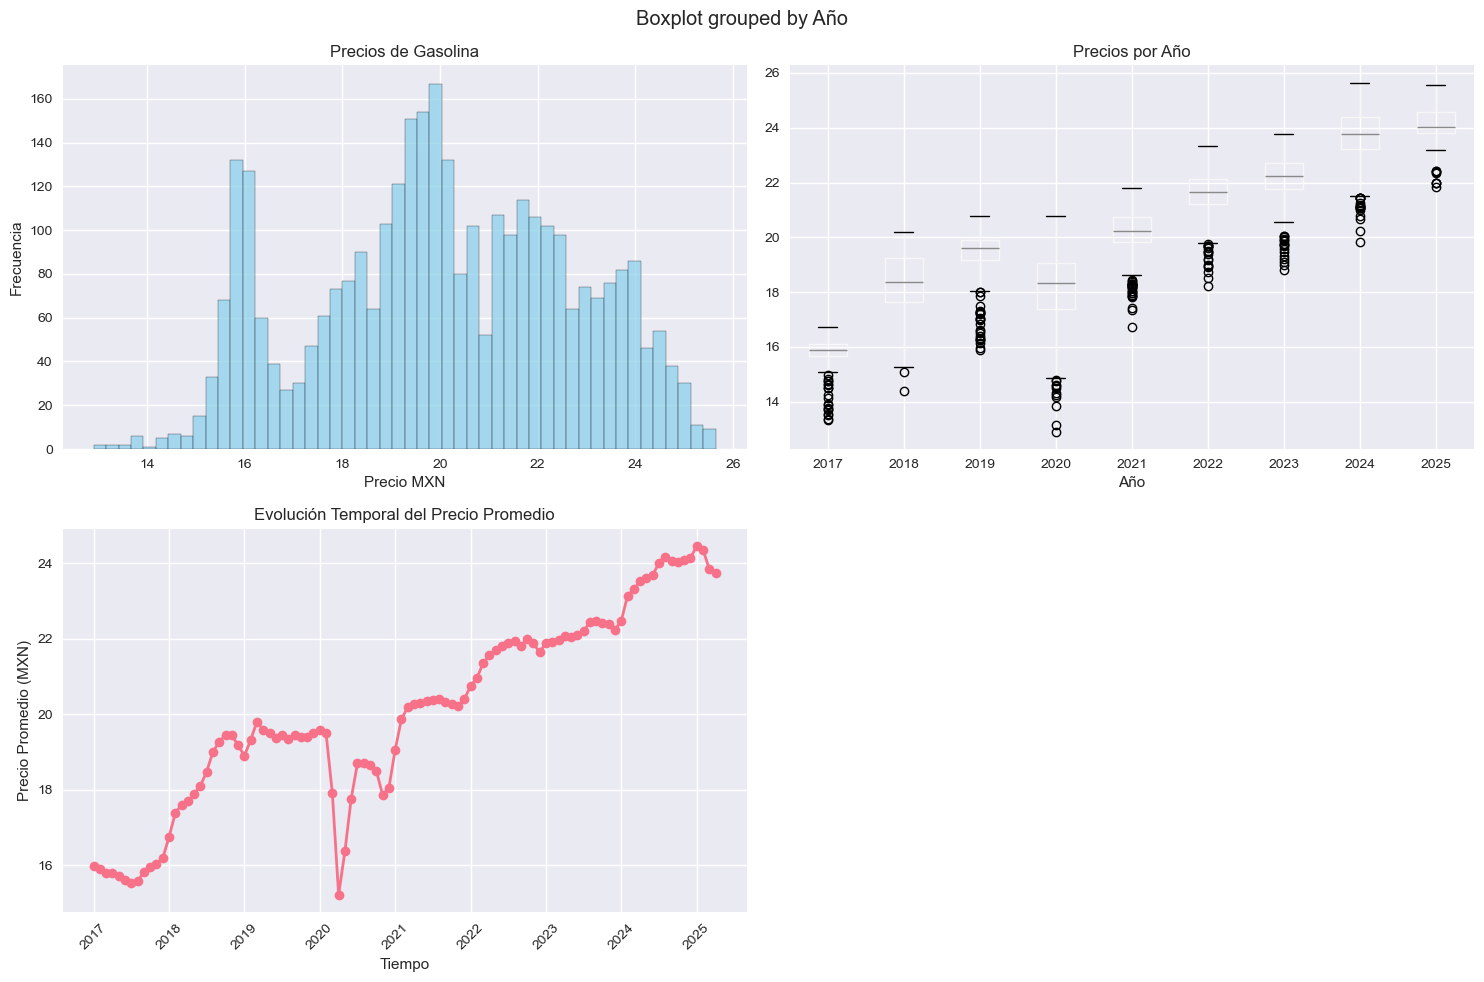

In [33]:
# Visualización de la distribución de precios
plt.figure(figsize=(15, 10))

# Histograma de precios
plt.subplot(2, 2, 1)
plt.hist(df_gasolina['Precio'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Precios de Gasolina')
plt.xlabel('Precio MXN')
plt.ylabel('Frecuencia')

# Boxplot de precios por año
plt.subplot(2, 2, 2)
df_gasolina.boxplot(column='Precio', by='Año', ax=plt.gca())
plt.title('Precios por Año')

# Evolución temporal del precio promedio
plt.subplot(2, 2, 3)
precio_temporal = df_gasolina.groupby(['Año', 'Mes'])['Precio'].mean().reset_index()
precio_temporal['Fecha'] = precio_temporal['Año'].astype(str) + '-' + precio_temporal['Mes'].astype(str)
plt.plot(range(len(precio_temporal)), precio_temporal['Precio'], marker='o', linewidth=2)
plt.title('Evolución Temporal del Precio Promedio')
plt.xlabel('Tiempo')
plt.ylabel('Precio Promedio (MXN)')
plt.xticks(range(0, len(precio_temporal), 12), [str(y) for y in sorted(df_gasolina['Año'].unique())], rotation=45)


plt.tight_layout()
plt.show()

## 3. Preparación de Datos para el Modelo

In [8]:
# Eliminar registros con valores faltantes
df_modelo = df_gasolina.dropna().copy()

print(f"Registros después de eliminar valores faltantes: {len(df_modelo)}")
print(f"Registros eliminados: {len(df_gasolina) - len(df_modelo)}")

Registros después de eliminar valores faltantes: 3300
Registros eliminados: 0


In [ ]:
# Codificación de variables categóricas
# Crear encoders para las variables categóricas
encoder_entidad = LabelEncoder()
encoder_mes = LabelEncoder()

# Aplicar encoding
df_modelo['Entidad_encoded'] = encoder_entidad.fit_transform(df_modelo['Entidad'])
df_modelo['Mes_encoded'] = encoder_mes.fit_transform(df_modelo['Mes'])

# Mostrar el mapeo de entidades
print("MAPEO DE ENTIDADES ")
entidad_mapping = dict(zip(encoder_entidad.classes_, encoder_entidad.transform(encoder_entidad.classes_)))
for entidad, codigo in sorted(entidad_mapping.items()):
    print(f"{codigo}: {entidad}")

print("\nMAPEO DE MESES")
mes_mapping = dict(zip(encoder_mes.classes_, encoder_mes.transform(encoder_mes.classes_)))
for mes, codigo in sorted(mes_mapping.items()):
    print(f"{codigo}: {mes}")

=== MAPEO DE ENTIDADES ===
0: Aguascalientes
1: Baja California
2: Baja California Sur
3: Campeche
4: Chiapas
5: Chihuahua
6: Ciudad de México
7: Coahuila de Zaragoza
8: Colima
9: Durango
10: Guanajuato
11: Guerrero
12: Hidalgo
13: Jalisco
14: Michoacán de Ocampo
15: Morelos
16: México
17: Nacional
18: Nayarit
19: Nuevo León
20: Oaxaca
21: Puebla
22: Querétaro
23: Quintana Roo
24: San Luis Potosí
25: Sinaloa
26: Sonora
27: Tabasco
28: Tamaulipas
29: Tlaxcala
30: Veracruz de Ignacio de la Llave
31: Yucatán
32: Zacatecas

=== MAPEO DE MESES ===
0: Abril
1: Agosto
2: Diciembre
3: Enero
4: Febrero
5: Julio
6: Junio
7: Marzo
8: Mayo
9: Noviembre
10: Octubre
11: Septiembre


## 4. Modelo de Regresión Lineal Múltiple

### 4.1 Preparación de Variables

In [34]:
# Definir variables independientes (X) y dependiente (y)
X = df_modelo[['Entidad_encoded', 'Mes_encoded', 'Año']]
y = df_modelo['Precio']

print(f"Forma de X: {X.shape}")
print(f"Forma de y: {y.shape}")
print(f"\nPrimeras 5 filas de X:")
print(X.head())

Forma de X: (3300, 3)
Forma de y: (3300,)

Primeras 5 filas de X:
   Entidad_encoded  Mes_encoded   Año
0                0            3  2017
1                0            4  2017
2                0            7  2017
3                0            0  2017
4                0            8  2017


### 4.2 División de Datos

In [35]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df_modelo['Entidad']
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")
print(f"Proporción de entrenamiento: {X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]):.2%}")
print(f"Proporción de prueba: {X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]):.2%}")

Tamaño del conjunto de entrenamiento: 2640
Tamaño del conjunto de prueba: 660
Proporción de entrenamiento: 80.00%
Proporción de prueba: 20.00%


### 4.3 Entrenamiento del Modelo

In [36]:
# Crear y entrenar el modelo de regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train)

print("MODELO ENTRENADO EXITOSAMENTE")
print(f"Intercepto: {modelo.intercept_:.4f}")
print(f"\nCoeficientes:")
for i, coef in enumerate(modelo.coef_):
    variable = X.columns[i]
    print(f"  {variable}: {coef:.4f}")

MODELO ENTRENADO EXITOSAMENTE
Intercepto: -1962.1963

Coeficientes:
  Entidad_encoded: -0.0079
  Mes_encoded: 0.0347
  Año: 0.9810


### 4.4 Evaluación del Modelo

In [38]:
# Realizar predicciones
y_pred_train = modelo.predict(X_train)
y_pred_test = modelo.predict(X_test)

# Calcular métricas de evaluación
# Entrenamiento
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Prueba
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("MÉTRICAS DE EVALUACIÓN")
print(f"\nConjunto de Entrenamiento:")
print(f"  R² Score: {r2_train:.4f}")
print(f"  MSE: {mse_train:.4f}")
print(f"  RMSE: {rmse_train:.4f}")
print(f"  MAE: {mae_train:.4f}")

print(f"\nConjunto de Prueba:")
print(f"  R² Score: {r2_test:.4f}")
print(f"  MSE: {mse_test:.4f}")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  MAE: {mae_test:.4f}")

print(f"\nDiferencia en R² (Entrenamiento - Prueba): {r2_train - r2_test:.4f}")

MÉTRICAS DE EVALUACIÓN

Conjunto de Entrenamiento:
  R² Score: 0.8004
  MSE: 1.3842
  RMSE: 1.1765
  MAE: 0.8870

Conjunto de Prueba:
  R² Score: 0.8099
  MSE: 1.3486
  RMSE: 1.1613
  MAE: 0.8855

Diferencia en R² (Entrenamiento - Prueba): -0.0094


### 4.5 Visualización de Resultados

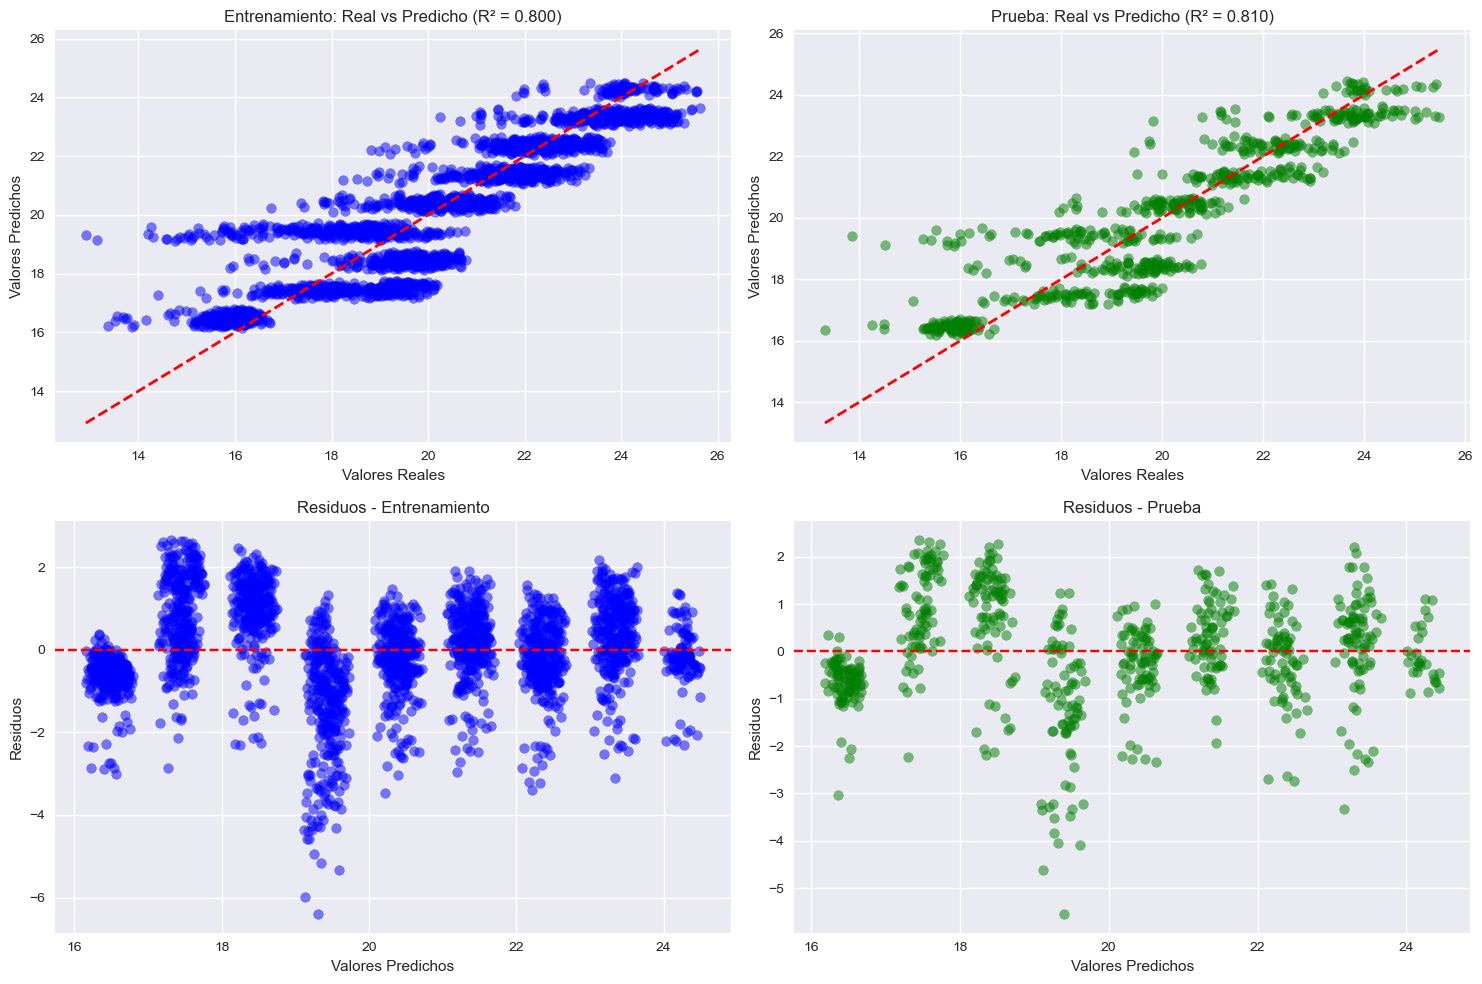

In [39]:
# Visualización de resultados
plt.figure(figsize=(15, 10))

# Gráfico de valores reales vs predichos (entrenamiento)
plt.subplot(2, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title(f'Entrenamiento: Real vs Predicho (R² = {r2_train:.3f})')

# Gráfico de valores reales vs predichos (prueba)
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title(f'Prueba: Real vs Predicho (R² = {r2_test:.3f})')

# Residuos (entrenamiento)
plt.subplot(2, 2, 3)
residuos_train = y_train - y_pred_train
plt.scatter(y_pred_train, residuos_train, alpha=0.5, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos - Entrenamiento')

# Residuos (prueba)
plt.subplot(2, 2, 4)
residuos_test = y_test - y_pred_test
plt.scatter(y_pred_test, residuos_test, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Residuos - Prueba')

plt.tight_layout()
plt.show()

## 5. Función de Predicción

In [41]:
def predecir_precio_gasolina(entidad, mes, año):
    """
    Predice el precio de la gasolina para una entidad, mes y año específicos.
    
    Args:
        entidad (str): Nombre de la entidad
        mes (str): Nombre del mes
        año (int): Año
    
    Returns:
        float: Precio predicho
    """
    try:
        # Verificar que la entidad existe
        if entidad not in encoder_entidad.classes_:
            return f"Error: La entidad '{entidad}' no existe en el dataset"
        
        # Verificar que el mes existe
        if mes not in encoder_mes.classes_:
            return f"Error: El mes '{mes}' no existe en el dataset"
        
        # Codificar las variables
        entidad_encoded = encoder_entidad.transform([entidad])[0]
        mes_encoded = encoder_mes.transform([mes])[0]
        
        # Crear el vector de características
        X_pred = np.array([[entidad_encoded, mes_encoded, año]])
        
        # Realizar la predicción
        precio_predicho = modelo.predict(X_pred)[0]
        
        return precio_predicho
        
    except Exception as e:
        return f"Error en la predicción: {str(e)}"

# Función para obtener listas de valores únicos
def obtener_opciones():
    """
    Retorna las opciones disponibles para entidad, mes y año.
    """
    entidades = sorted(df_modelo['Entidad'].unique())
    meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
             'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
    años = sorted(df_modelo['Año'].unique())
    
    return entidades, meses, años